## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp026'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    #backbone = 'se_resnext50_32x4d'
    backbone = 'timm-resnest50d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

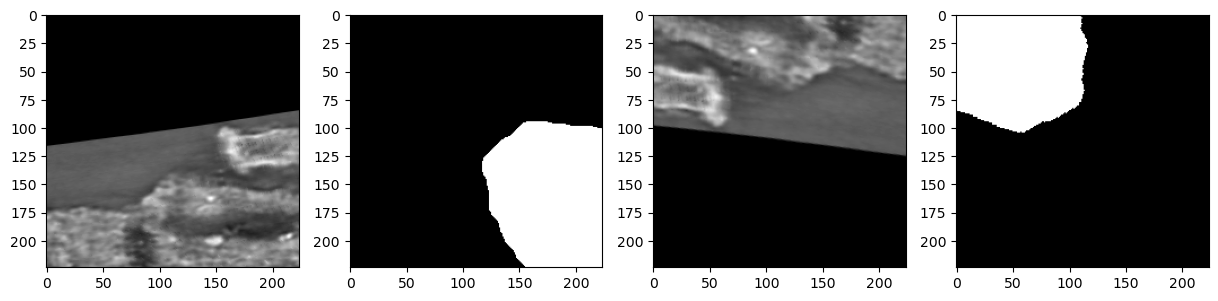

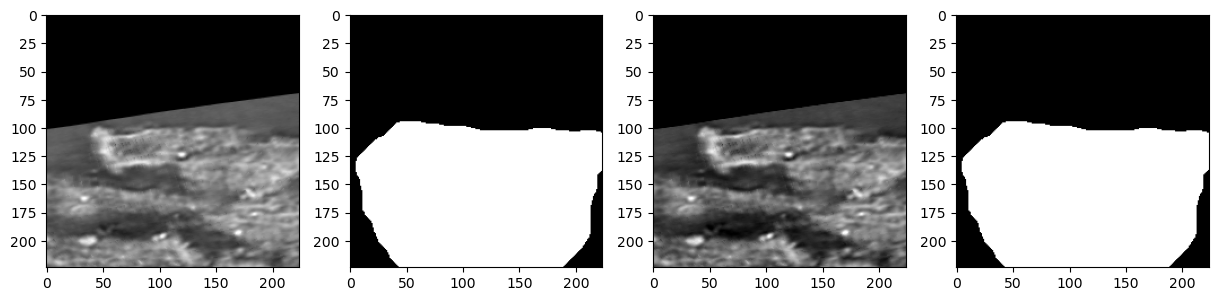

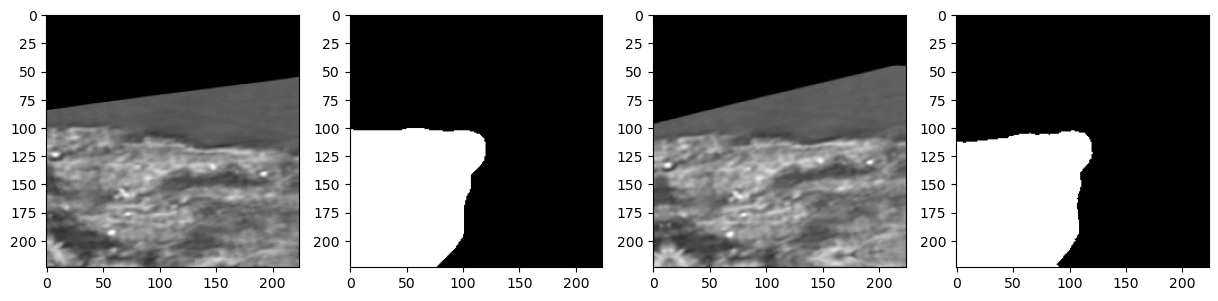

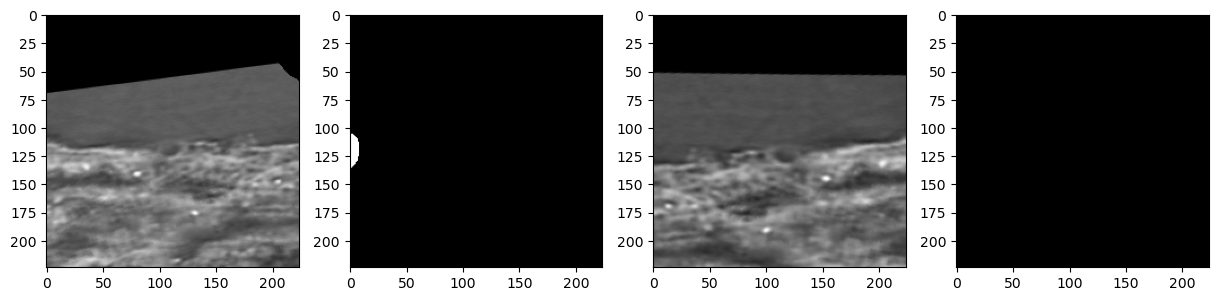

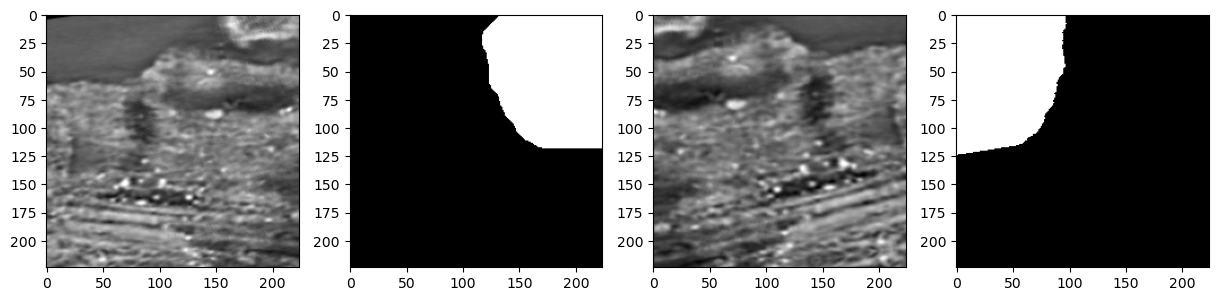

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone timm-resnest50d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09524972342930257
th: 0.15, fbeta: 0.09639644612828305
th: 0.2, fbeta: 0.15776798381379667
th: 0.25, fbeta: 0.17084259784937134
th: 0.3, fbeta: 0.18972410570117548
th: 0.35, fbeta: 0.21687101734691963
th: 0.4, fbeta: 0.2545444857787963
th: 0.45, fbeta: 0.3008611121574299


best_th: 0.5, fbeta: 0.34829329157487426
Epoch 1 - avg_train_loss: 0.5628  avg_val_loss: 0.3962  time: 178s
Epoch 1 - avgScore: 0.3483
Epoch 1 - Save Best Score: 0.3483 Model
Epoch 1 - Save Best Loss: 0.3962 Model


th: 0.5, fbeta: 0.34829329157487426


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09742542170141683
th: 0.15, fbeta: 0.16680587341507316
th: 0.2, fbeta: 0.19843706883982293
th: 0.25, fbeta: 0.24805438199441118
th: 0.3, fbeta: 0.3088325774306571
th: 0.35, fbeta: 0.3684824730825487
th: 0.4, fbeta: 0.41583487593006496


best_th: 0.5, fbeta: 0.4584510346408784
Epoch 2 - avg_train_loss: 0.3719  avg_val_loss: 0.2951  time: 181s
Epoch 2 - avgScore: 0.4585
Epoch 2 - Save Best Score: 0.4585 Model
Epoch 2 - Save Best Loss: 0.2951 Model


th: 0.45, fbeta: 0.4467633381038088
th: 0.5, fbeta: 0.4584510346408784


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.24158105652887946
th: 0.15, fbeta: 0.3808429295282707
th: 0.2, fbeta: 0.4451204862982442
th: 0.25, fbeta: 0.47306568178574815
th: 0.3, fbeta: 0.48657504453475536
th: 0.35, fbeta: 0.49488838716122013
th: 0.4, fbeta: 0.4993654127045489


best_th: 0.4, fbeta: 0.4993654127045489
Epoch 3 - avg_train_loss: 0.2960  avg_val_loss: 0.2076  time: 182s
Epoch 3 - avgScore: 0.4994
Epoch 3 - Save Best Score: 0.4994 Model
Epoch 3 - Save Best Loss: 0.2076 Model


th: 0.45, fbeta: 0.48976193505673593
th: 0.5, fbeta: 0.4586675805961615


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3508426381350812
th: 0.15, fbeta: 0.4193971389100361
th: 0.2, fbeta: 0.4638492386155623
th: 0.25, fbeta: 0.4940290972577431
th: 0.3, fbeta: 0.5179527502474329
th: 0.35, fbeta: 0.5364142690479181
th: 0.4, fbeta: 0.5485702971408978


best_th: 0.5, fbeta: 0.5634167661690385


th: 0.45, fbeta: 0.559360798133673
th: 0.5, fbeta: 0.5634167661690385


Epoch 4 - avg_train_loss: 0.2639  avg_val_loss: 0.1891  time: 181s
Epoch 4 - avgScore: 0.5634
Epoch 4 - Save Best Score: 0.5634 Model
Epoch 4 - Save Best Loss: 0.1891 Model


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.5082207171733383
th: 0.15, fbeta: 0.5601095015640792
th: 0.2, fbeta: 0.5750176400245581
th: 0.25, fbeta: 0.5767061926832303
th: 0.3, fbeta: 0.568960916073086
th: 0.35, fbeta: 0.5524149898183944
th: 0.4, fbeta: 0.5327827882426769
th: 0.45, fbeta: 0.5095420980425405


best_th: 0.25, fbeta: 0.5767061926832303
Epoch 5 - avg_train_loss: 0.2521  avg_val_loss: 0.2006  time: 182s
Epoch 5 - avgScore: 0.5767
Epoch 5 - Save Best Score: 0.5767 Model
Epoch 5 - Save Best Loss: 0.2006 Model


th: 0.5, fbeta: 0.4795549732049876


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3144803741682046
th: 0.15, fbeta: 0.39453610316549703
th: 0.2, fbeta: 0.4576351168425687
th: 0.25, fbeta: 0.4982820501895744
th: 0.3, fbeta: 0.5277637075255621
th: 0.35, fbeta: 0.5486046889616195
th: 0.4, fbeta: 0.5573995262572954
th: 0.45, fbeta: 0.5550859343806628


best_th: 0.4, fbeta: 0.5573995262572954
Epoch 6 - avg_train_loss: 0.2525  avg_val_loss: 0.1830  time: 184s
Epoch 6 - avgScore: 0.5574


th: 0.5, fbeta: 0.5498098916333622


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28542272586851375
th: 0.15, fbeta: 0.3687112831185533
th: 0.2, fbeta: 0.4310198144163898
th: 0.25, fbeta: 0.48097453063226087
th: 0.3, fbeta: 0.5129421961220682
th: 0.35, fbeta: 0.5370145325038315
th: 0.4, fbeta: 0.551642155888324
th: 0.45, fbeta: 0.557317170440151


best_th: 0.45, fbeta: 0.557317170440151
Epoch 7 - avg_train_loss: 0.2323  avg_val_loss: 0.1840  time: 184s
Epoch 7 - avgScore: 0.5573


th: 0.5, fbeta: 0.5516050550983466


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3391981150609154
th: 0.15, fbeta: 0.40188243246524175
th: 0.2, fbeta: 0.44592552224328275
th: 0.25, fbeta: 0.4787575800433555
th: 0.3, fbeta: 0.5045147199359848
th: 0.35, fbeta: 0.5260806553598223
th: 0.4, fbeta: 0.5446185975355592


best_th: 0.5, fbeta: 0.5675337488353707
Epoch 8 - avg_train_loss: 0.2239  avg_val_loss: 0.1815  time: 181s
Epoch 8 - avgScore: 0.5675


th: 0.45, fbeta: 0.5576725043662003
th: 0.5, fbeta: 0.5675337488353707


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25300011594758187
th: 0.15, fbeta: 0.2985788520263478
th: 0.2, fbeta: 0.3326954028988392
th: 0.25, fbeta: 0.3628869094115979
th: 0.3, fbeta: 0.3912681533657913
th: 0.35, fbeta: 0.41942397618821753
th: 0.4, fbeta: 0.44830405656567124
th: 0.45, fbeta: 0.4751450644588188


best_th: 0.5, fbeta: 0.49930066242240184
Epoch 9 - avg_train_loss: 0.2179  avg_val_loss: 0.2122  time: 182s
Epoch 9 - avgScore: 0.4993


th: 0.5, fbeta: 0.49930066242240184


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4178702792842812
th: 0.15, fbeta: 0.4727744991907878
th: 0.2, fbeta: 0.5115915287860926
th: 0.25, fbeta: 0.5387894362893904
th: 0.3, fbeta: 0.5589778137163329
th: 0.35, fbeta: 0.5736284837050013
th: 0.4, fbeta: 0.5833595708547666
th: 0.45, fbeta: 0.588047941950361


best_th: 0.45, fbeta: 0.588047941950361
Epoch 10 - avg_train_loss: 0.2187  avg_val_loss: 0.1884  time: 181s
Epoch 10 - avgScore: 0.5880
Epoch 10 - Save Best Score: 0.5880 Model
Epoch 10 - Save Best Loss: 0.1884 Model


th: 0.5, fbeta: 0.5877763681415841


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30025269430767254
th: 0.15, fbeta: 0.3643998866685436
th: 0.2, fbeta: 0.41548121728455306
th: 0.25, fbeta: 0.4558791619036799
th: 0.3, fbeta: 0.5004059193503687
th: 0.35, fbeta: 0.5448240863081173
th: 0.4, fbeta: 0.5785620817708436
th: 0.45, fbeta: 0.5998281055581575


best_th: 0.5, fbeta: 0.6132622288100879
Epoch 11 - avg_train_loss: 0.1985  avg_val_loss: 0.1769  time: 182s
Epoch 11 - avgScore: 0.6133
Epoch 11 - Save Best Score: 0.6133 Model
Epoch 11 - Save Best Loss: 0.1769 Model


th: 0.5, fbeta: 0.6132622288100879


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26940253067074693
th: 0.15, fbeta: 0.3118512064256524
th: 0.2, fbeta: 0.3482424880691383
th: 0.25, fbeta: 0.38347313332652694
th: 0.3, fbeta: 0.41718295806623185
th: 0.35, fbeta: 0.4523459352181311
th: 0.4, fbeta: 0.48581465458418244


best_th: 0.5, fbeta: 0.5376616533366697
Epoch 12 - avg_train_loss: 0.1908  avg_val_loss: 0.1988  time: 181s


th: 0.45, fbeta: 0.514997968462806
th: 0.5, fbeta: 0.5376616533366697


Epoch 12 - avgScore: 0.5377


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33514859442607076
th: 0.15, fbeta: 0.3762576216098274
th: 0.2, fbeta: 0.4126101314925194
th: 0.25, fbeta: 0.4445917826090186
th: 0.3, fbeta: 0.4740477212423013
th: 0.35, fbeta: 0.49847964563081265
th: 0.4, fbeta: 0.5162898232300969
th: 0.45, fbeta: 0.5298904109523666


best_th: 0.5, fbeta: 0.5392107286636098
Epoch 13 - avg_train_loss: 0.1909  avg_val_loss: 0.2066  time: 182s
Epoch 13 - avgScore: 0.5392


th: 0.5, fbeta: 0.5392107286636098


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37872649083354487
th: 0.15, fbeta: 0.43176829997373034
th: 0.2, fbeta: 0.4692807877165923
th: 0.25, fbeta: 0.4966782350574515
th: 0.3, fbeta: 0.5152795919282868
th: 0.35, fbeta: 0.5339280929005005
th: 0.4, fbeta: 0.5508978976226399


best_th: 0.5, fbeta: 0.5766449468888446
Epoch 14 - avg_train_loss: 0.1732  avg_val_loss: 0.1919  time: 182s
Epoch 14 - avgScore: 0.5766


th: 0.45, fbeta: 0.5646906180173842
th: 0.5, fbeta: 0.5766449468888446


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3845790549917058
th: 0.15, fbeta: 0.4387717317810774
th: 0.2, fbeta: 0.4784741478951957
th: 0.25, fbeta: 0.5068102218668146
th: 0.3, fbeta: 0.5277067144802036
th: 0.35, fbeta: 0.5471465737932417
th: 0.4, fbeta: 0.5620281646377225


best_th: 0.45, fbeta: 0.5703953788543418
Epoch 15 - avg_train_loss: 0.1765  avg_val_loss: 0.1949  time: 181s
Epoch 15 - avgScore: 0.5704


th: 0.45, fbeta: 0.5703953788543418
th: 0.5, fbeta: 0.569998805443626


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3357206325621995
th: 0.15, fbeta: 0.3901236107176731
th: 0.2, fbeta: 0.43214861613190864
th: 0.25, fbeta: 0.4667800616280931
th: 0.3, fbeta: 0.49766002753726346
th: 0.35, fbeta: 0.526103761938998
th: 0.4, fbeta: 0.5469624895594289
th: 0.45, fbeta: 0.5638158254809882


best_th: 0.5, fbeta: 0.575665258350385
Epoch 16 - avg_train_loss: 0.1657  avg_val_loss: 0.1958  time: 181s
Epoch 16 - avgScore: 0.5757


th: 0.5, fbeta: 0.575665258350385


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2760835130819727
th: 0.15, fbeta: 0.3065714801308822
th: 0.2, fbeta: 0.33196173015661923
th: 0.25, fbeta: 0.35535884870524076
th: 0.3, fbeta: 0.37819202427558785
th: 0.35, fbeta: 0.4022486804486309
th: 0.4, fbeta: 0.42664750843617155
th: 0.45, fbeta: 0.4512978053059196


best_th: 0.5, fbeta: 0.47554913800649445
Epoch 17 - avg_train_loss: 0.1514  avg_val_loss: 0.2500  time: 181s
Epoch 17 - avgScore: 0.4755


th: 0.5, fbeta: 0.47554913800649445


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4191333584160891
th: 0.15, fbeta: 0.4667572634336151
th: 0.2, fbeta: 0.5011961919359169
th: 0.25, fbeta: 0.5316349949136531
th: 0.3, fbeta: 0.5544914139619587
th: 0.35, fbeta: 0.5655966926004087
th: 0.4, fbeta: 0.5747250624857897


best_th: 0.45, fbeta: 0.5790423663884045
Epoch 18 - avg_train_loss: 0.1439  avg_val_loss: 0.2091  time: 182s
Epoch 18 - avgScore: 0.5790


th: 0.45, fbeta: 0.5790423663884045
th: 0.5, fbeta: 0.5780761010508685


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40033290022783585
th: 0.15, fbeta: 0.44167983106362807
th: 0.2, fbeta: 0.47211514518611114
th: 0.25, fbeta: 0.49700740224611994
th: 0.3, fbeta: 0.5205294549839201
th: 0.35, fbeta: 0.5385299646870341
th: 0.4, fbeta: 0.5532480871042147
th: 0.45, fbeta: 0.5649650711382977


best_th: 0.5, fbeta: 0.572022268816461
Epoch 19 - avg_train_loss: 0.1382  avg_val_loss: 0.2143  time: 181s
Epoch 19 - avgScore: 0.5720


th: 0.5, fbeta: 0.572022268816461


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36021851396735477
th: 0.15, fbeta: 0.3971661914314178
th: 0.2, fbeta: 0.4299977375428119
th: 0.25, fbeta: 0.45631386208984137
th: 0.3, fbeta: 0.48082322054450166
th: 0.35, fbeta: 0.5033563069220843
th: 0.4, fbeta: 0.5224651278760357
th: 0.45, fbeta: 0.5400746022670663


best_th: 0.5, fbeta: 0.554452099705074
Epoch 20 - avg_train_loss: 0.1308  avg_val_loss: 0.2148  time: 181s
Epoch 20 - avgScore: 0.5545


th: 0.5, fbeta: 0.554452099705074


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33121882575592576
th: 0.15, fbeta: 0.3720123280649983
th: 0.2, fbeta: 0.40682054289687436
th: 0.25, fbeta: 0.43534100855487273
th: 0.3, fbeta: 0.4593784736211378
th: 0.35, fbeta: 0.48282141639157605
th: 0.4, fbeta: 0.5031745146402209
th: 0.45, fbeta: 0.5193207617236477


best_th: 0.5, fbeta: 0.5316989001707438
Epoch 21 - avg_train_loss: 0.1221  avg_val_loss: 0.2279  time: 182s
Epoch 21 - avgScore: 0.5317


th: 0.5, fbeta: 0.5316989001707438


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37755931846135143
th: 0.15, fbeta: 0.4293802165874431
th: 0.2, fbeta: 0.46673785109462795
th: 0.25, fbeta: 0.49962787523383917
th: 0.3, fbeta: 0.5241679006995151
th: 0.35, fbeta: 0.5441245089010919
th: 0.4, fbeta: 0.5600990300374279
th: 0.45, fbeta: 0.5686473525349443


best_th: 0.5, fbeta: 0.5747981772619354
Epoch 22 - avg_train_loss: 0.1182  avg_val_loss: 0.2082  time: 188s
Epoch 22 - avgScore: 0.5748


th: 0.5, fbeta: 0.5747981772619354


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3892654002079399
th: 0.15, fbeta: 0.4273796253845327
th: 0.2, fbeta: 0.45854623935382816
th: 0.25, fbeta: 0.48306439449330196
th: 0.3, fbeta: 0.5040922921893634
th: 0.35, fbeta: 0.5248758898833259
th: 0.4, fbeta: 0.5423904317945403
th: 0.45, fbeta: 0.5531671772960812


best_th: 0.5, fbeta: 0.5624481798115541
Epoch 23 - avg_train_loss: 0.1129  avg_val_loss: 0.2209  time: 184s
Epoch 23 - avgScore: 0.5624


th: 0.5, fbeta: 0.5624481798115541


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3617323945532986
th: 0.15, fbeta: 0.3996332090925361
th: 0.2, fbeta: 0.4281563863900975
th: 0.25, fbeta: 0.45359681519451994
th: 0.3, fbeta: 0.4748948995292925
th: 0.35, fbeta: 0.49191748728272533
th: 0.4, fbeta: 0.51055753182024
th: 0.45, fbeta: 0.5262804149201803


best_th: 0.5, fbeta: 0.5393336214315194
Epoch 24 - avg_train_loss: 0.1077  avg_val_loss: 0.2388  time: 184s
Epoch 24 - avgScore: 0.5393


th: 0.5, fbeta: 0.5393336214315194


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32435539484790993
th: 0.15, fbeta: 0.3544316094268975
th: 0.2, fbeta: 0.38005847007526433
th: 0.25, fbeta: 0.40411307805298535
th: 0.3, fbeta: 0.42562989037595633
th: 0.35, fbeta: 0.445348239577342
th: 0.4, fbeta: 0.4625391611532694
th: 0.45, fbeta: 0.4774835403441458


best_th: 0.5, fbeta: 0.4914577593185832
Epoch 25 - avg_train_loss: 0.1043  avg_val_loss: 0.2496  time: 183s
Epoch 25 - avgScore: 0.4915


th: 0.5, fbeta: 0.4914577593185832


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40404613424597324
th: 0.15, fbeta: 0.4414875055549004
th: 0.2, fbeta: 0.46816488116379185
th: 0.25, fbeta: 0.4932481320946272
th: 0.3, fbeta: 0.5132736023760119
th: 0.35, fbeta: 0.5305300897228269
th: 0.4, fbeta: 0.545640477927992
th: 0.45, fbeta: 0.558727781629391


best_th: 0.5, fbeta: 0.5662897368209079
Epoch 26 - avg_train_loss: 0.1010  avg_val_loss: 0.2363  time: 182s
Epoch 26 - avgScore: 0.5663


th: 0.5, fbeta: 0.5662897368209079


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3846407733834684
th: 0.15, fbeta: 0.4169609374663978
th: 0.2, fbeta: 0.4444129325837314
th: 0.25, fbeta: 0.46784568585929814
th: 0.3, fbeta: 0.487876460377352
th: 0.35, fbeta: 0.5058218139675981
th: 0.4, fbeta: 0.5227297095143929


best_th: 0.5, fbeta: 0.551082189270227
Epoch 27 - avg_train_loss: 0.0976  avg_val_loss: 0.2448  time: 183s
Epoch 27 - avgScore: 0.5511


th: 0.45, fbeta: 0.5388420284742361
th: 0.5, fbeta: 0.551082189270227


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38802570800560493
th: 0.15, fbeta: 0.4229759644546291
th: 0.2, fbeta: 0.4497225684410647
th: 0.25, fbeta: 0.47779666159770334
th: 0.3, fbeta: 0.5000007758197615
th: 0.35, fbeta: 0.5189029799926715
th: 0.4, fbeta: 0.5344483676371429
th: 0.45, fbeta: 0.5489701988992067


best_th: 0.5, fbeta: 0.561520315523562
Epoch 28 - avg_train_loss: 0.0951  avg_val_loss: 0.2380  time: 182s
Epoch 28 - avgScore: 0.5615


th: 0.5, fbeta: 0.561520315523562


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40105111396261495
th: 0.15, fbeta: 0.43781543841268605
th: 0.2, fbeta: 0.46728952708223515
th: 0.25, fbeta: 0.4905594160564292
th: 0.3, fbeta: 0.5096853171342037
th: 0.35, fbeta: 0.5261183973337306
th: 0.4, fbeta: 0.5425341101754922
th: 0.45, fbeta: 0.5568365248401688


best_th: 0.5, fbeta: 0.5674115773442321
Epoch 29 - avg_train_loss: 0.0947  avg_val_loss: 0.2357  time: 183s
Epoch 29 - avgScore: 0.5674


th: 0.5, fbeta: 0.5674115773442321


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39619408407308243
th: 0.15, fbeta: 0.4335209261519362
th: 0.2, fbeta: 0.4622217191573112
th: 0.25, fbeta: 0.48612931174594587
th: 0.3, fbeta: 0.5070649257352027
th: 0.35, fbeta: 0.5256688104049432
th: 0.4, fbeta: 0.5414740014408952


best_th: 0.5, fbeta: 0.5643181322135405
Epoch 30 - avg_train_loss: 0.0919  avg_val_loss: 0.2363  time: 184s
Epoch 30 - avgScore: 0.5643


th: 0.45, fbeta: 0.5537752784963845
th: 0.5, fbeta: 0.5643181322135405


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.30025269430767254
th: 0.15, fbeta: 0.3643998866685436
th: 0.2, fbeta: 0.41548121728455306
th: 0.25, fbeta: 0.4558791619036799
th: 0.3, fbeta: 0.5004059193503687
th: 0.35, fbeta: 0.5448240863081173
th: 0.4, fbeta: 0.5785620817708436
th: 0.45, fbeta: 0.5998281055581575


best_th: 0.5, fbeta: 0.6132622288100879


th: 0.5, fbeta: 0.6132622288100879


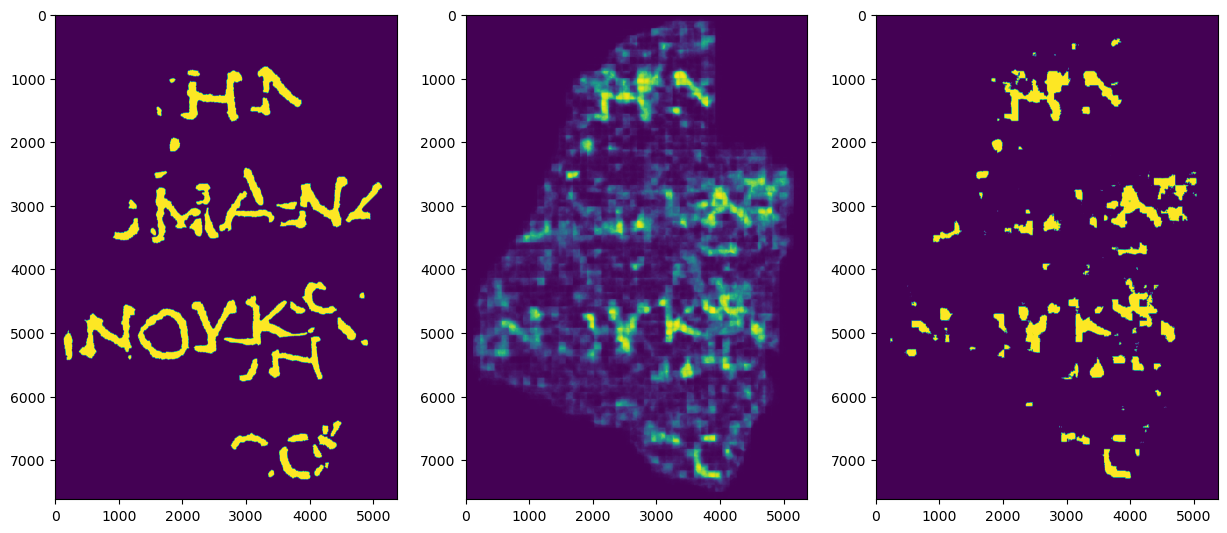

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([24398698.,  5463680.,  2700210.,  1681211.,  1245766.,   968096.,
          788726.,   598534.,   463303.,   396675.,   353819.,   287230.,
          257133.,   245993.,   235568.,   216503.,   201556.,   190248.,
          178552.,    72115.]),
 array([2.59323915e-05, 4.88816742e-02, 9.77374161e-02, 1.46593158e-01,
        1.95448900e-01, 2.44304642e-01, 2.93160383e-01, 3.42016125e-01,
        3.90871867e-01, 4.39727609e-01, 4.88583351e-01, 5.37439093e-01,
        5.86294835e-01, 6.35150576e-01, 6.84006318e-01, 7.32862060e-01,
        7.81717802e-01, 8.30573544e-01, 8.79429286e-01, 9.28285028e-01,
        9.77140769e-01]),
 <BarContainer object of 20 artists>)

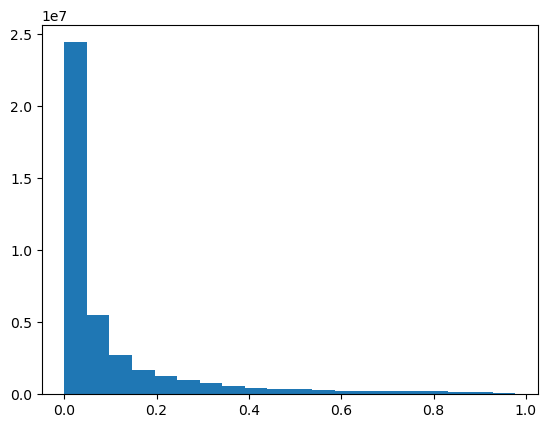

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000